In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from keras.preprocessing.image import load_img
%matplotlib inline
from tqdm.notebook import tqdm
import os

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
base='/content/drive/MyDrive/UTKFace'
image_paths=[]
age_labels=[]
gender_labels=[]

for filename in tqdm(os.listdir(base)):
    image_path=os.path.join(base, filename)
    temp=filename.split('_')
    age=int(temp[0])
    gender=int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23748 [00:00<?, ?it/s]

# New section

In [16]:
data=pd.DataFrame()
data['image'],data['age'], data['gender']=image_paths,age_labels, gender_labels
# in the gender label, 1 is female, 0 is male

In [ ]:
data.head()

image  age  gender
0  /content/drive/MyDrive/UTKFace/8_1_0_201701092...    8       1
1  /content/drive/MyDrive/UTKFace/75_0_1_20170113...   75       0
2  /content/drive/MyDrive/UTKFace/73_1_0_20170120...   73       1
3  /content/drive/MyDrive/UTKFace/8_0_0_201701102...    8       0
4  /content/drive/MyDrive/UTKFace/7_0_0_201701102...    7       0

In [17]:
data=data.iloc[:18000]

In [ ]:
data.shape

(20000, 3)

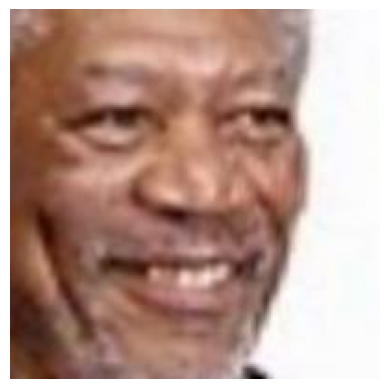

In [18]:
gender_dict={0:'Male',1:'Female'}
#using PIl Image to open and visualize the images in the dataframe
from PIL import Image
img=Image.open(data['image'][1])
plt.axis('off')
plt.imshow(img)

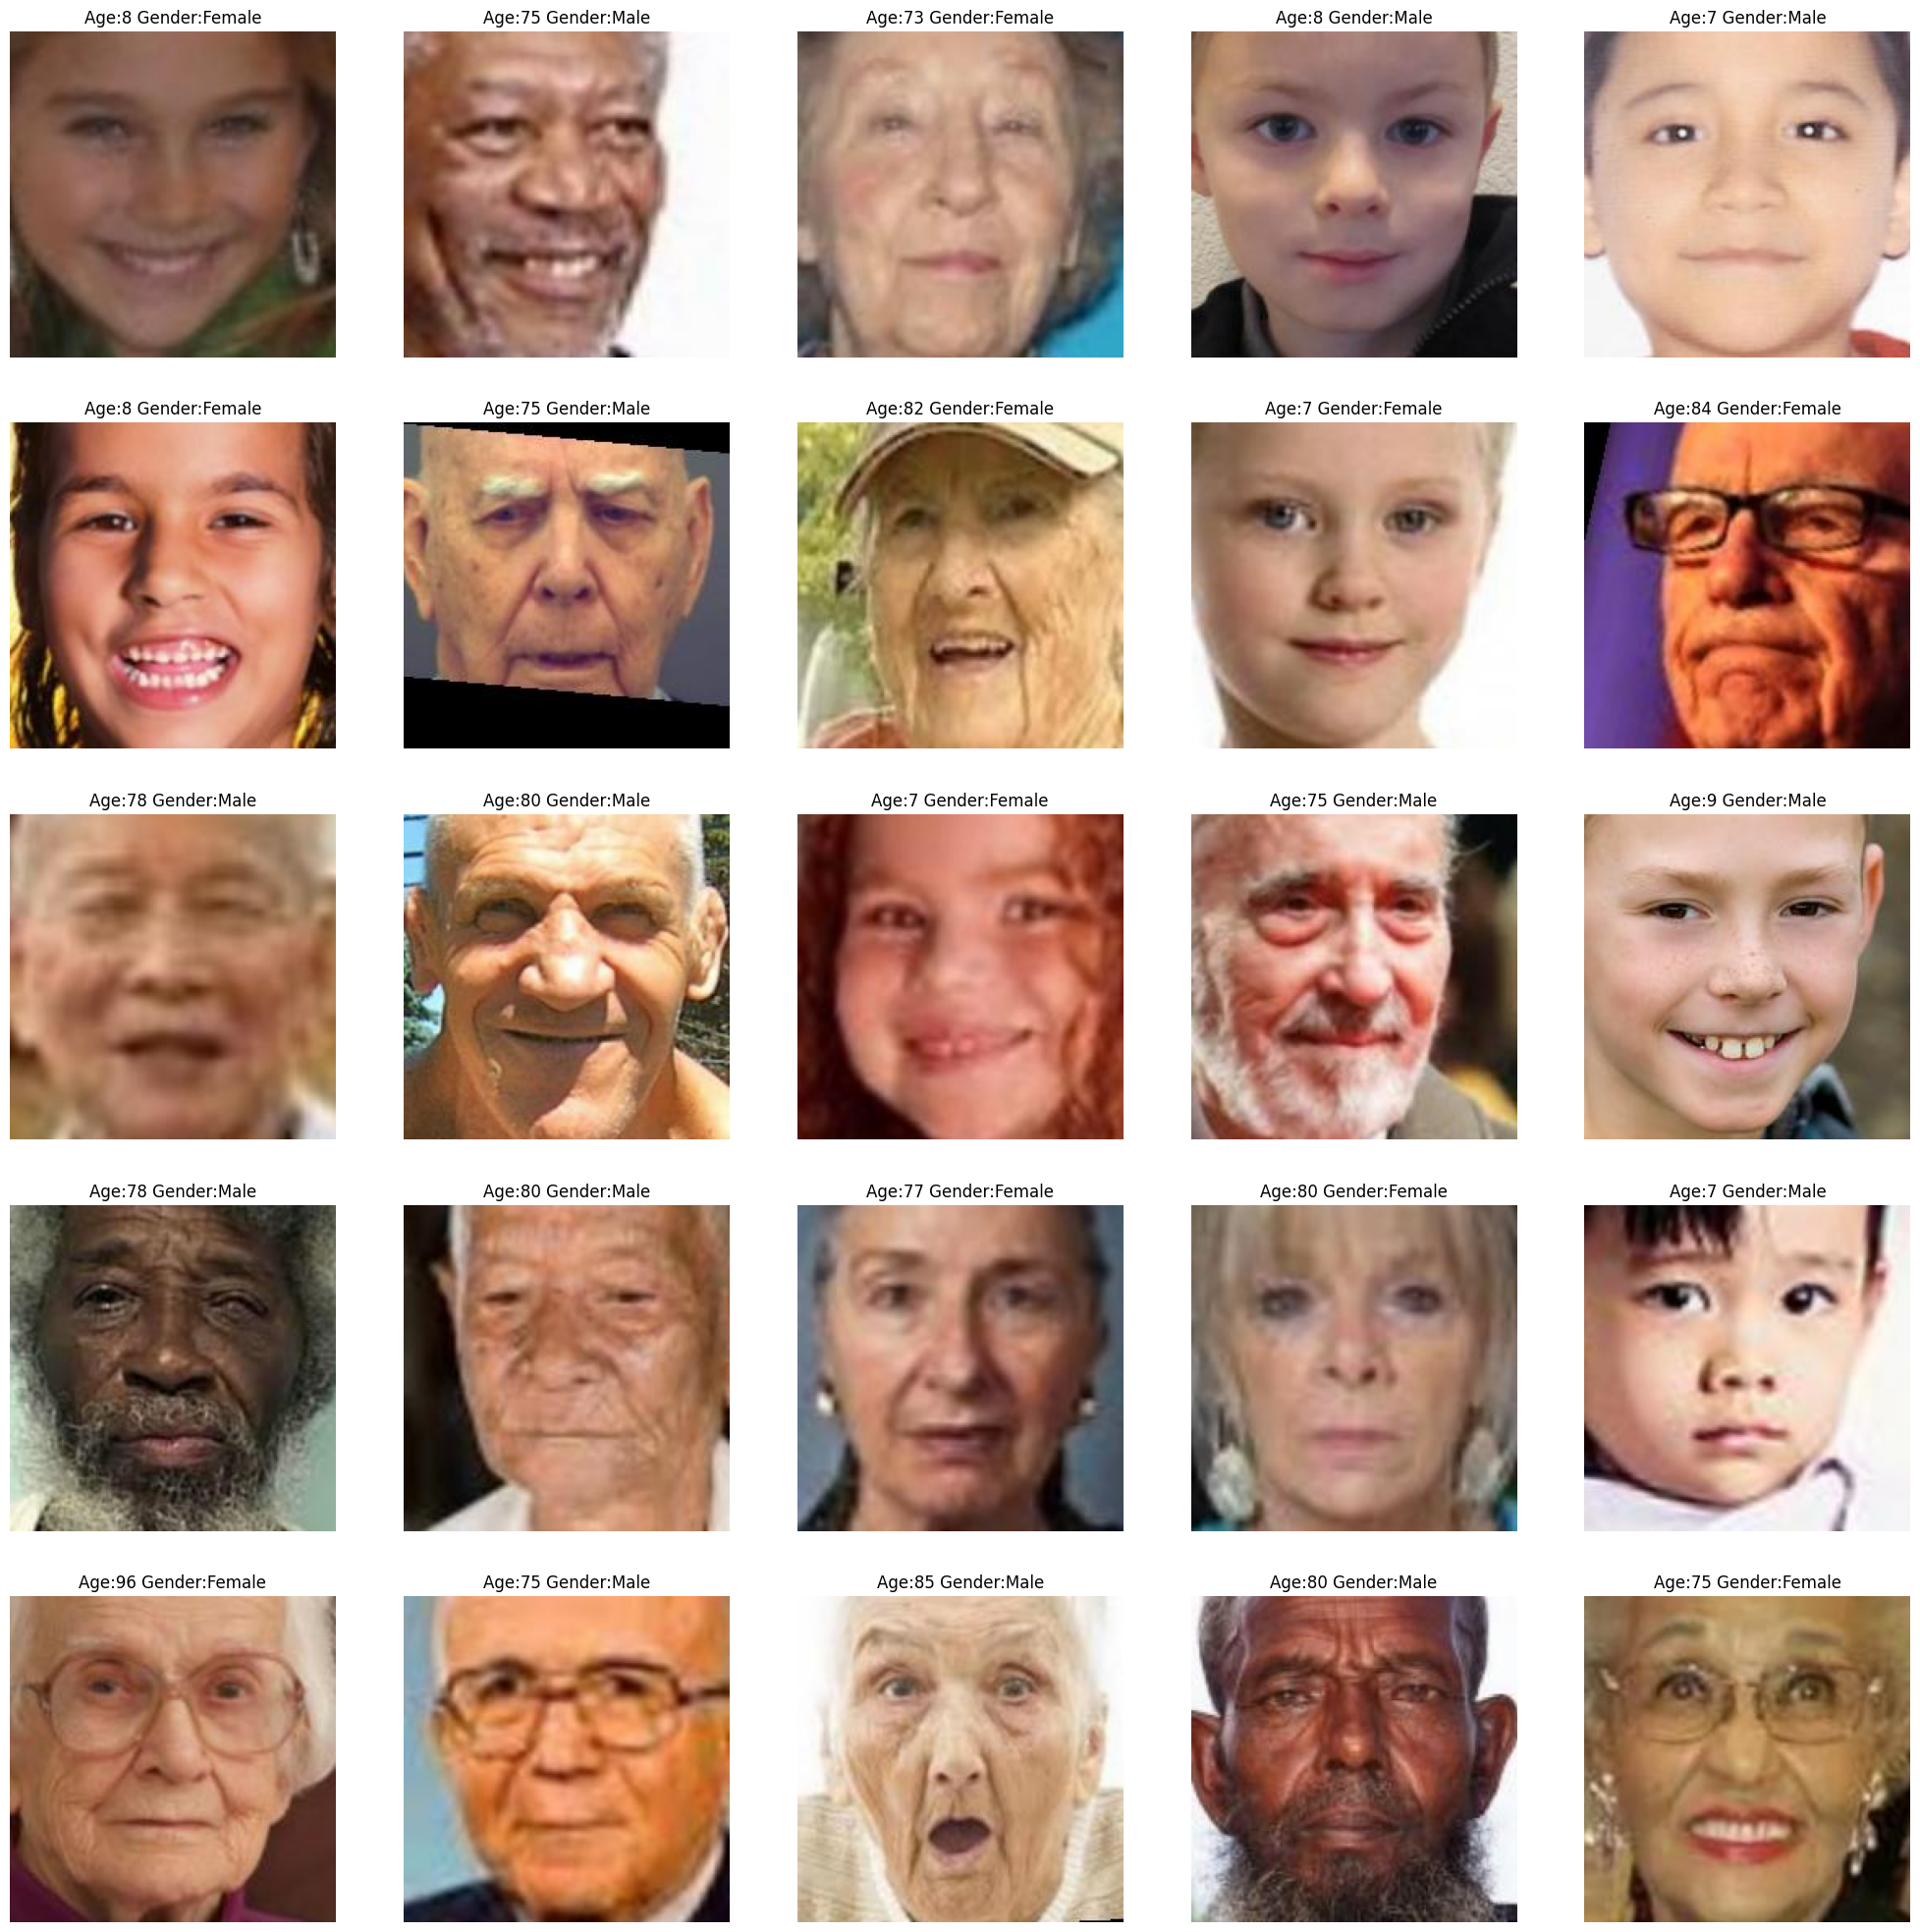

In [19]:
plt.figure(figsize=(25,25))
files=data.iloc[0:25]
for index, file,age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img=load_img(file)
    img=np.array(img)
    plt.imshow(img)
    plt.title(f"Age:{age} Gender:{gender_dict[gender]}")
    plt.axis('off')

In [20]:
def features_images(images):
    features=[]
    for image in tqdm(images):
        img=load_img(image, grayscale=True)
        img=img.resize((128,128), Image.ANTIALIAS)
        img=np.array(img)
        features.append(img)
    features=np.array(features)
    #features=features.reshape(len(features),128,128, 1)
    return features

In [21]:
x=features_images(data['image'])

  0%|          | 0/18000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
<ipython-input-20-175a069b3b3c>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img=img.resize((128,128), Image.ANTIALIAS)


In [22]:
#normalization
X=x/255.0

In [23]:
y_gender=np.array(data['gender'])
y_age=np.array(data['age'])
input_shape=(128,128,1)

In [24]:
# Model Building
inputs=Input((input_shape))
#these are the convolutional layers
convolution=Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
max1=MaxPool2D(pool_size=(2,2))(convolution)

convol2=Conv2D(64, kernel_size=(3,3), activation='relu')(max1)
max2=MaxPool2D(pool_size=(2,2))(convol2)

convol3=Conv2D(128, kernel_size=(3,3), activation='relu')(max2)
max3=MaxPool2D(pool_size=(2,2))(convol3)

convol4=Conv2D(256, kernel_size=(3,3), activation='relu')(max3)
max4=MaxPool2D(pool_size=(2,2))(convol4)

#flatten comverts into a single dimensionsal layer
flat=Flatten()(max4)

dense1=Dense(256, activation='relu')(flat)
dense2=Dense(256, activation='relu')(flat)

dropout1=Dropout(0.3)(dense1)
dropout2=Dropout(0.3)(dense2)

output1=Dense(1, activation='sigmoid',name='gender_output')(dropout1)
output2=Dense(1, activation='relu', name='age_output')(dropout2)

model=Model(inputs=[inputs], outputs=[output1,output2])
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0]']   

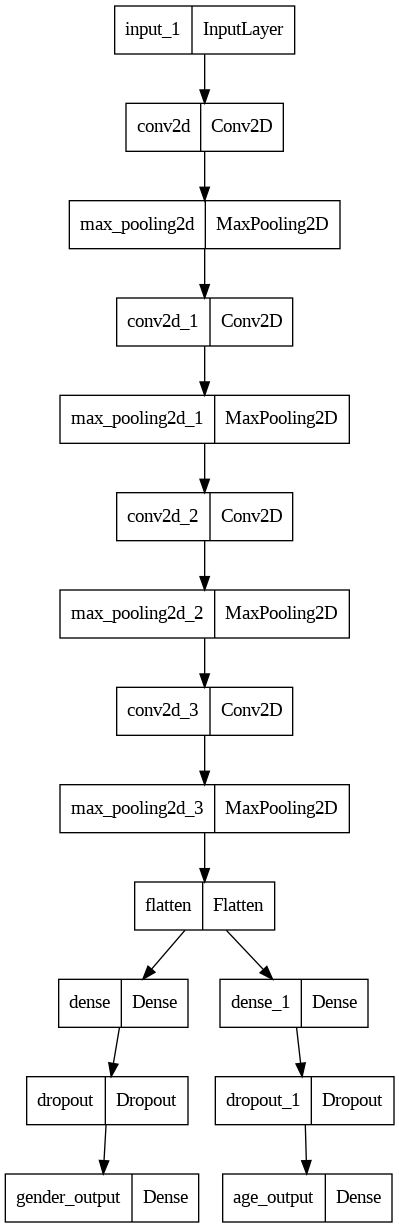

In [26]:
from keras.utils import plot_model
plot_model(model)

In [27]:
history=model.fit(x=X, y=[y_gender,y_age], batch_size=32, epochs=20, validation_split=.2)

Epoch 1/20
450/450 [==============================] - 594s 1s/step - loss: 17.2827 - gender_output_loss: 0.7040 - age_output_loss: 16.5787 - gender_output_accuracy: 0.5801 - age_output_accuracy: 0.0000e+00 - val_loss: 8.6730 - val_gender_output_loss: 0.6222 - val_age_output_loss: 8.0508 - val_gender_output_accuracy: 0.6803 - val_age_output_accuracy: 0.0000e+00
Epoch 2/20
450/450 [==============================] - 585s 1s/step - loss: 13.2259 - gender_output_loss: 0.5359 - age_output_loss: 12.6899 - gender_output_accuracy: 0.7423 - age_output_accuracy: 0.0000e+00 - val_loss: 20.2267 - val_gender_output_loss: 0.4975 - val_age_output_loss: 19.7292 - val_gender_output_accuracy: 0.8019 - val_age_output_accuracy: 0.0000e+00
Epoch 3/20
450/450 [==============================] - 589s 1s/step - loss: 11.5207 - gender_output_loss: 0.4601 - age_output_loss: 11.0606 - gender_output_accuracy: 0.7904 - age_output_accuracy: 0.0000e+00 - val_loss: 9.0283 - val_gender_output_loss: 0.3632 - val_age_outp

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, *, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

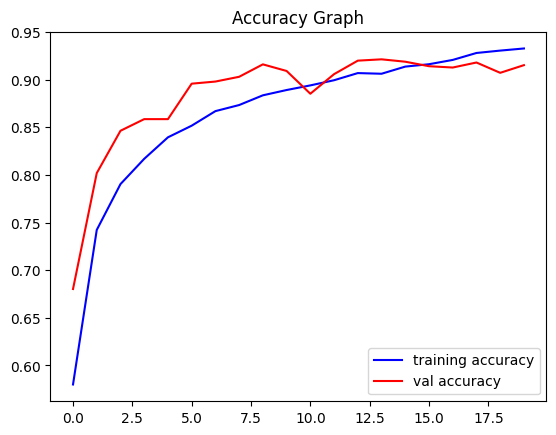

In [28]:
acc=history.history['gender_output_accuracy']
val_acc=history.history['val_gender_output_accuracy']
epochs=range(len(acc))

plt.plot(epochs, acc, 'b', label='training accuracy')

plt.plot(epochs, val_acc,'r',label='val accuracy')

plt.title('Accuracy Graph')
plt.legend()
plt.figure





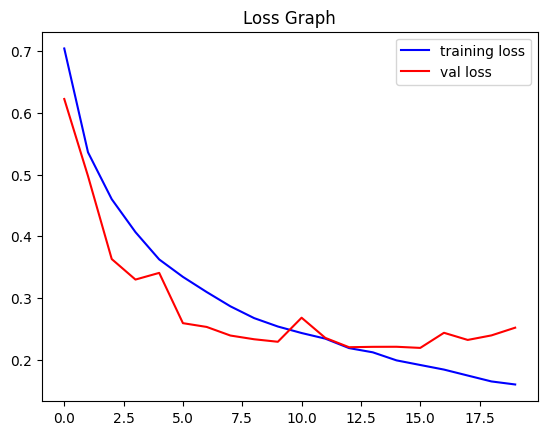

<Figure size 640x480 with 0 Axes>

In [29]:
loss=history.history['gender_output_loss']
val_loss=history.history['val_gender_output_loss']
epochs=range(len(loss))

plt.plot(epochs, loss, 'b', label='training loss')

plt.plot(epochs, val_loss,'r',label='val loss')

plt.title('Loss Graph')
plt.legend()
plt.figure()
plt.show()

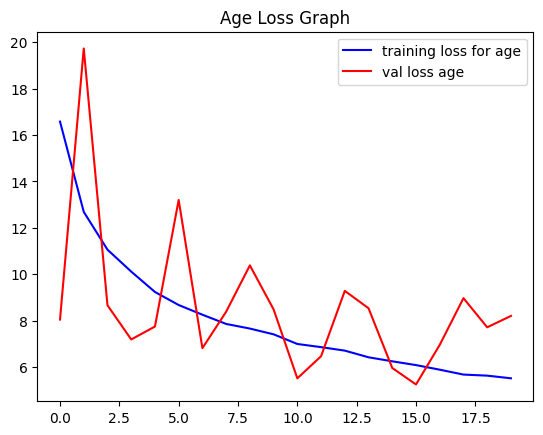

<Figure size 640x480 with 0 Axes>

In [30]:
loss_age=history.history['age_output_loss']
val_loss_age=history.history['val_age_output_loss']
epochs=range(len(loss_age))

plt.plot(epochs, loss_age, 'b', label='training loss for age')

plt.plot(epochs, val_loss_age,'r',label='val loss age')

plt.title('Age Loss Graph')
plt.legend()
plt.figure()
plt.show()

original gender Female origianl_age 73
1/1 [==============================] - 0s 62ms/step
predicted gender Female predicted age 88


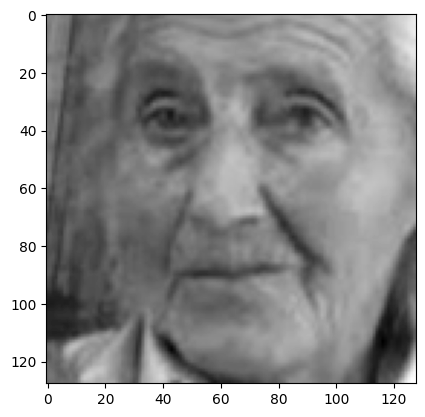

In [40]:
image_index=1500
print('original gender', gender_dict[y_gender[image_index]], 'origianl_age',y_age[image_index])
y_pred=model.predict(X[image_index].reshape(1,128,128,1))
pred_gen=gender_dict[round(y_pred[0][0][0])]
pred_age=round(y_pred[1][0][0])

print('predicted gender', pred_gen, 'predicted age', pred_age)

plt.imshow(X[image_index].reshape(128,128), cmap='gray')